In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
tissue_data_fn = '../../python/tissue_classifier/datasets/tissue_dataset_withglue.npz'

In [3]:
data = np.load(tissue_data_fn)

In [4]:
x = data['x']
y = data['y']
d = data['d']

In [16]:
x.shape

(35421067, 3)

In [17]:
y.shape

(35421067,)

In [19]:
d.shape

(35421067, 4)

### Test split inference

In [5]:
import sys
import numpy as np

import pyeddl.eddl as eddl
import pyecvl.ecvl as ecvl
from pyeddl.tensor import Tensor

sys.path.append('../../python/')
import models
import pickle

In [6]:
def load_model(model_weights, gpu=True):
    ## Load the ANN tissue detector model implemented by using pyeddl
    ## Create ANN topology (Same used during training phase)
    ## The model is assumed being trained by using RGB triplets.
    net = models.tissue_detector_DNN()
    eddl.build(
        net,
        eddl.rmsprop(0.00001),
        ["soft_cross_entropy"],
        ["categorical_accuracy"],
        eddl.CS_GPU() if gpu else eddl.CS_CPU()
    )
    # Load weights
    eddl.load(net, model_weights, "bin")

    return net


In [7]:
data = pickle.load(open("../../python/tissue_classifier/splits_used.pckl", "rb"))

In [8]:
N = data["x_test"].shape[0]
x_test = data['x_test']
y_test = data['y_test']

In [9]:
model_fn = '../../python/tissue_classifier/tissue_detector_model.bin'
net = load_model(model_fn)
eddl.summary(net)

bs = 1024
n_batches = N // bs

In [10]:
results = []

for b_index in range(n_batches):
    #print (b_index*bs, (b_index+1)*bs)
    x = Tensor(x_test[b_index*bs:(b_index+1)*bs])
    
    eddl.forward(net, [x])

    net_out = eddl.getOutput(net.layers[-1]).getdata()
    for r in net_out:
        results.append(r)
        
results = np.array(results)

In [11]:
y_test_samples = y_test[0:results.shape[0]]
results.shape == y_test_samples.shape

True

In [14]:
import numpy as np
from sklearn import metrics

y_true = y_test_samples[:,0]
y_pred = results[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
print ("AUC: %.3f" % auc)

AUC: 0.988


In [15]:
a_s_l = []
pred = np.zeros_like(y_pred)
th = thresholds[1::10000]
bar = tqdm(th)
for t in bar:
    pred[y_pred >= t] = 1
    pred[y_pred < t] = 0
    a_s = metrics.accuracy_score(y_true, pred)
    a_s_l.append(a_s)

m_val = max(a_s_l)
th_m_val = th[np.argmax(a_s_l)]

  0%|          | 0/48 [00:00<?, ?it/s]

In [16]:
prec, rec, th_pr = metrics.precision_recall_curve(y_true, y_pred)
th_m_val_index = np.where(th_pr == th_m_val)
print (prec[th_m_val_index], rec[th_m_val_index])

diff2 = np.power((prec[1:]-rec[1:]),2.0)
th_min_diff = th_pr[diff2.argmin()]

[0.91422843] [0.99467023]


In [17]:
print (m_val)
print (th_m_val)

0.9506687173679361
0.6107428


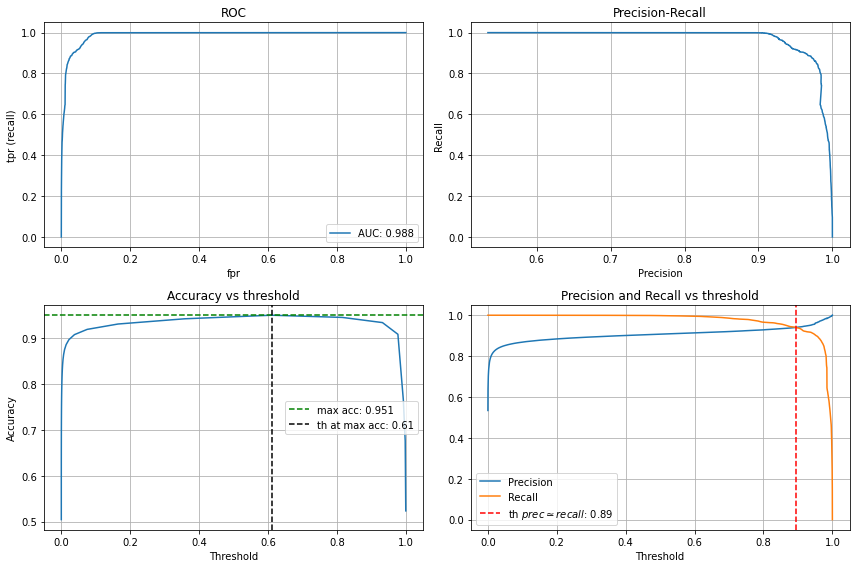

In [18]:
fig, axs = plt.subplots(2,2,figsize=(12,8))

ax = axs[0,0]
ax.plot(fpr, tpr, label='AUC: %.3f' % auc)
ax.legend(loc='lower right')
ax.grid()
ax.set_xlabel('fpr')
ax.set_ylabel('tpr (recall)')
ax.set_title('ROC')

ax = axs[0,1]
ax.plot(prec, rec)
ax.grid()
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall')

ax = axs[1,0]
ax.plot(th, a_s_l)
ax.axhline(m_val, label='max acc: %.3f' % m_val, c='g', ls = '--')
ax.axvline(th_m_val, label='th at max acc: %.2f' % th_m_val, c='k', ls='--')
#ax.axvline(th_min_diff, c='r', ls='--', label=r'th $prec \approx recall$: %.2f' % th_min_diff)
ax.legend()
ax.grid()
ax.set_title('Accuracy vs threshold')
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')

ax = axs[1,1]
ax.plot(th_pr[:], prec[1:], label='Precision')
ax.plot(th_pr[:], rec[1:], label='Recall')
ax.axvline(th_min_diff, c='r', ls='--', label=r'th $prec \simeq recall$: %.2f' % th_min_diff)
#ax.axvline(th_m_val, label='th at max acc: %.2f' % th_m_val, c='k', ls='--')
ax.grid()
ax.legend()
ax.set_xlabel('Threshold')
ax.set_title('Precision and Recall vs threshold')

plt.tight_layout()